In [161]:
import pandas as pd
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
import seaborn as sns

from copy import copy
from unidecode import unidecode
from bias_correction import BiasCorrection, XBiasCorrection
from modules import forecast
from itertools import combinations
from scipy.stats import pearsonr

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2_score 

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
%load_ext autoreload
%autoreload 2

### 1. Read Data

- ERA, ECCC, GFDL (1993-2021)
- raw wheat yield (1993-2021)

In [162]:
# WHEAT
wheat = pd.read_csv("data/crop/national_yield_with_trend.csv")
# ECCC
eccc = pd.read_csv("c3s/data/ECCC_operational/ECCC_operational.csv").drop(columns=["geometry", "lat", "lon"])
eccc = eccc.loc[eccc["year"] <= 2020].reset_index(drop=True) 
# GFDL
gfdl = pd.read_csv("nmme/data/GFDL2/GFDL2.csv")
gfdl = gfdl.loc[(gfdl["init_month"] == 10) & (gfdl["year"] <= 2020)].reset_index(drop=True) # wheat data until 2021, but ECCC incomplete for 2021
# ERA
era = pd.read_csv("c3s/data/era_filtered_locations_v2.csv").assign(model="ERA", init_month=12)
era = era.loc[era["year"] <= 2020].reset_index(drop=True) 
era["name"] = era["name"].apply(lambda x: x.replace("buenos aires ", ""))
era = era[["model", "year", "init_month", "month", "rain", "tmean", "name"]]
era.columns = ["model", "year", "init_month", "forecasted_month", "rain", "tmean", "location"]

In [163]:
eccc.head(2)

,model,year,init_month,forecasted_month,rain,tmean,location
0,ECCC,1993,10,10,0.001470,15.418512,coronel suarez
1,ECCC,1993,10,11,0.001637,18.105188,coronel suarez


In [164]:
gfdl.head(2)

,model,year,init_month,forecasted_month,rain,tmean,location
0,GFDL,1993,10,10,0.003076,17.004449,coronel suarez
1,GFDL,1993,10,11,0.002176,19.719324,coronel suarez


In [165]:
era.head(2)

,model,year,init_month,forecasted_month,rain,tmean,location
0,ERA,1993,12,8,0.000122,10.427311,bahia blanca
1,ERA,1993,12,9,0.000719,12.046370,bahia blanca


In [166]:
wheat.head(2)

,year,harvested area [ha],yield [kg/ha]
0,1969,5058530,1361.123558
1,1970,3553500,1331.921649


### 2. Filter and preprocess

- preprocess ECCC and GFDL according to their notebooks and directly filter locations and features
- bias adjustment of ECCC and GFDL without LOYOCV, instead moving forward
- wheat yield trend adjustment

In [167]:
# wheat yield trend adjustment
years_to_params = {}
trend_estimated = []
for year in list(range(1993,2021)):
    years_to_params[year] = {"slope":np.nan, "bias":np.nan}
    year_range = wheat.loc[wheat["year"].isin(list(range(year-23, year))), ["year", "yield [kg/ha]"]]
    slope, bias= np.polyfit(year_range["year"], year_range["yield [kg/ha]"], deg=1)
    years_to_params[year]["slope"] = slope
    years_to_params[year]["bias"] = bias

for year in list(range(1993,2021)):
    value = year * years_to_params[year]["slope"] + years_to_params[year]["bias"]
    trend_estimated.append(value)

wheat = wheat.loc[wheat["year"].isin(list(range(1993,2021)))].reset_index(drop=True)
wheat["yield_trend [kg/ha]"] = trend_estimated
wheat["yield anomaly [%]"] = (wheat["yield [kg/ha]"] - wheat["yield_trend [kg/ha]"])/wheat["yield_trend [kg/ha]"]

In [168]:
# bias adjustment
def adjust_bias(observed, predicted, correction_method="basic_quantile"):
    """Apply bias-adjustment to daily temperature values of hindcasts.
    
    parameters:
     - observed: observed climate data
     - predicted: hindcast data
     - correction_method: bias-correction method to be applied. Can be 'normal_mapping', 'basic_quantile', 'gamma_mapping', 'modified_quantile'
    
    returns: 
     - results: bias-adjusted hindcasts as dataframe  
    """
    # GroupBy objects allow faster access to relevant subsets of climate data.
    grouped_climate_observations = observed.groupby(["location", "year", "forecasted_month"])
    grouped_climate_hindcasts = predicted.groupby(["model", "init_month", "location", "year", "forecasted_month"])
    grouped_climate_hindcasts_reference = copy(grouped_climate_hindcasts)
    li = []
    
    for group_idx, group_content in grouped_climate_hindcasts:
        # Save group characteristics in intuitive variables.
        current_model = group_content["model"].unique()[0]
        current_init_month = group_content["init_month"].unique()[0]
        current_zone = group_content["location"].unique()[0]
        current_season = group_content["year"].unique()[0]
        current_month = group_content["forecasted_month"].unique()[0]
        
        # Create calibration set of observations and hindcasts.
        hindcasts_used_as_reference = []
        observations_used_as_reference = []
        if current_season < 2017:
            iterate_years = list(range(1993,2017))
            for season in iterate_years: 
                if season != current_season:
                    observation_to_be_added = (current_zone, season, current_month) 
                    observations_used_as_reference.append(grouped_climate_observations.get_group(observation_to_be_added))   
                hindcast_to_be_added = (current_model, current_init_month, current_zone, season, current_month)
                hindcasts_used_as_reference.append(grouped_climate_hindcasts_reference.get_group(hindcast_to_be_added))
            hindcasts_used_as_reference = pd.concat(hindcasts_used_as_reference, axis=0, ignore_index=False)
            observations_used_as_reference = pd.concat(observations_used_as_reference, axis=0, ignore_index=False) 
        if current_season >= 2017:
            iterate_years = list(range(1993,current_season))
            for season in iterate_years: 
                observation_to_be_added = (current_zone, season, current_month) 
                observations_used_as_reference.append(grouped_climate_observations.get_group(observation_to_be_added))   
                hindcast_to_be_added = (current_model, current_init_month, current_zone, season, current_month)
                hindcasts_used_as_reference.append(grouped_climate_hindcasts_reference.get_group(hindcast_to_be_added))
            hindcast_to_be_added = (current_model, current_init_month, current_zone, current_season, current_month)
            hindcasts_used_as_reference = pd.concat(hindcasts_used_as_reference, axis=0, ignore_index=False)
            observations_used_as_reference = pd.concat(observations_used_as_reference, axis=0, ignore_index=False)
        
        # Perform bias-adjustment for temperature variables.
        bc_tmean = BiasCorrection(observations_used_as_reference["tmean"], hindcasts_used_as_reference["tmean"], group_content["tmean"])
        bc_rain = BiasCorrection(observations_used_as_reference["rain"], hindcasts_used_as_reference["rain"], group_content["rain"])
        group_content["tmean"] = bc_tmean.correct(method=correction_method)
        group_content["rain"] = bc_rain.correct(method=correction_method)
        
        li.append(group_content)
    result = pd.concat(li, axis=0, ignore_index=True)       
    
    return result

In [169]:
hindcasts = pd.concat([gfdl, eccc], ignore_index=True)

In [170]:
adjusted_hindcasts = adjust_bias(era, hindcasts)

In [171]:
# Bring hindcasts into right structure where features are columns and rows are model-year-init_month
hindcasts_pivot = adjusted_hindcasts.pivot(index=["model", "year", "init_month"], columns=["location", "forecasted_month"], values=["tmean", "rain"]).reset_index()
hindcasts_pivot.columns = ["{}_{}_{}".format(c[0], c[1], c[2]) for c in hindcasts_pivot.columns]
hindcasts_pivot.columns = [c.strip("_") for c in hindcasts_pivot.columns]

# Bring ERA into right structure where features are columns and rows are model-year
era_pivot = era.pivot(index=["model", "year", "init_month"], columns=["location", "forecasted_month"], values=["tmean", "rain"]).reset_index()
era_pivot.columns = ["{}_{}_{}".format(c[0], c[1], c[2]) for c in era_pivot.columns]
era_pivot.columns = [c.strip("_") for c in era_pivot.columns]
era_pivot = era_pivot.sort_values(by=["model", "year", "init_month"])

# features for month < init_months are NaNs and will be replaced with era-reanalysis data
all_models = hindcasts_pivot.set_index("year").combine_first(era_pivot.set_index("year")).reset_index()
# concat ERA with init_month = 12  
all_models = pd.concat([all_models, era_pivot], ignore_index=True)
all_models = all_models.drop_duplicates().reset_index(drop=True)
all_models = all_models.loc[all_models["init_month"] >= 9].sort_values(by=["model", "year", "init_month"]).reset_index(drop=True)


In [172]:
# prepare dataset
all_models = all_models.merge(wheat[["year", "yield [kg/ha]", "yield anomaly [%]"]], on="year", how="left").sort_values(by="year").reset_index(drop=True)

In [176]:
all_models.sort_values(by="year")

,year,init_month,model,rain_bahia blanca_10,rain_bahia blanca_11,rain_bahia blanca_8,rain_bahia blanca_9,rain_coronel dorrego_10,rain_coronel dorrego_11,rain_coronel dorrego_8,...,tmean_saavedra_10,tmean_saavedra_11,tmean_saavedra_8,tmean_saavedra_9,tmean_santa fe san justo_10,tmean_santa fe san justo_11,tmean_santa fe san justo_8,tmean_santa fe san justo_9,yield [kg/ha],yield anomaly [%]
0,1993,10,ECCC,0.001597,0.001821,0.000122,0.000719,0.001651,0.002024,0.000204,...,13.594179,16.094196,8.826087,10.539790,20.121783,21.852503,13.974337,15.597872,2037.439151,-0.046171
1,1993,10,GFDL,0.002756,0.004716,0.000122,0.000719,0.003906,0.005223,0.000204,...,14.344004,16.049334,8.826087,10.539790,19.447595,21.606272,13.974337,15.597872,2037.439151,-0.046171
2,1993,12,ERA,0.002106,0.003066,0.000122,0.000719,0.001886,0.002961,0.000204,...,14.453463,15.948329,8.826087,10.539790,19.565541,20.987172,13.974337,15.597872,2037.439151,-0.046171
3,1994,10,ECCC,0.002551,0.002966,0.001336,0.000796,0.003155,0.003260,0.001294,...,14.271663,17.346171,8.094497,11.147357,19.628086,22.248360,13.629018,17.975140,2185.741998,0.018138
4,1994,10,GFDL,0.003259,0.001805,0.001336,0.000796,0.003333,0.003444,0.001294,...,13.339877,15.862197,8.094497,11.147357,18.435443,21.118191,13.629018,17.975140,2185.741998,0.018138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,2019,10,GFDL,0.000849,0.001836,0.000177,0.001023,0.001809,0.002507,0.000302,...,12.958923,15.935778,8.589443,11.143642,20.316564,22.915172,13.549358,15.976639,3052.327504,-0.117583
80,2019,12,ERA,0.002181,0.001462,0.000177,0.001023,0.002514,0.002074,0.000302,...,13.664150,19.169138,8.589443,11.143642,18.972245,23.635749,13.549358,15.976639,3052.327504,-0.117583
82,2020,10,ECCC,0.001267,0.001083,0.000871,0.001217,0.000582,0.000842,0.000963,...,15.124684,18.822679,8.831188,11.058074,20.084019,22.938504,16.041232,16.507331,2909.162980,-0.154634
81,2020,12,ERA,0.001603,0.001438,0.000871,0.001217,0.002341,0.002152,0.000963,...,13.453463,19.144500,8.831188,11.058074,20.600140,23.627204,16.041232,16.507331,2909.162980,-0.154634


In [184]:
li = []
for model in ['ERA', 'GFDL', 'ECCC']:

    X = all_models.loc[(all_models["model"] == model), [c for c in all_models.columns if ("_9" in c) or ("_10" in c) or ("_11" in c)]].reset_index(drop=True)
    y = all_models.loc[(all_models["model"] == model), ['model', 'year', 'init_month', 'yield [kg/ha]', 'yield anomaly [%]']].reset_index(drop=True)
    X_columns = X.columns
    
    # scale features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X_columns)

    # store features and target in variables for better readability
    X_temp = X.loc[:, [c for c in X.columns if ("tmean" in c)]]
    X_rain = X.loc[:, [c for c in X.columns if ("rain" in c)]]
    # basis expansion to linear model
    X_tmean_squared = pd.DataFrame(np.array(np.multiply(X_temp, X_temp)), columns=["tt_10_a", "tt_11_a", "tt_9_a", "tt_10_b", "tt_11_b", "tt_9_b", "tt_10_c", "tt_11_c", "tt_9_c", 
                                                                               "tt_10_d", "tt_11_d", "tt_9_d", "tt_10_e", "tt_11_e", "tt_9_e", "tt_10_f", "tt_11_f", "tt_9_f", "tt_10_g", "tt_11_g", "tt_9_g"])
    X_rain_squared = pd.DataFrame(np.array(np.multiply(X_rain, X_rain)), columns=["rr_10_a", "rr_11_a", "rr_9_a", "rr_10_b", "rr_11_b", "rr_9_b", "rr_10_c", "rr_11_c", "rr_9_c", 
                                                                               "rr_10_d", "rr_11_d", "rr_9_d", "rr_10_e", "rr_11_e", "rr_9_e", "rr_10_f", "rr_11_f", "rr_9_f", "rr_10_g", "rr_11_g", "rr_9_g"])
    X_tmean_times_rain = pd.DataFrame(np.multiply(np.array(X_temp), np.array(X_rain)), columns=["rt_10_a", "rt_11_a", "rt_9_a", "rt_10_b", "rt_11_b", "rt_9_b", "rt_10_c", "rt_11_c", "rt_9_c", 
                                                                               "rt_10_d", "rt_11_d", "rt_9_d", "rt_10_e", "rt_11_e", "rt_9_e", "rt_10_f", "rt_11_f", "rt_9_f", "rt_10_g", "rt_11_g", "rt_9_g"])

    # merge to feature dataframe
    X = (X_tmean_squared.merge(X_rain_squared.merge(X_tmean_times_rain, left_index=True, right_index=True), left_index=True, right_index=True))

    df = pd.concat([y, X], axis=1)
    li.append(df)

x_y_cv_expanded = pd.concat(li, ignore_index=True)
x_y_cv_expanded = x_y_cv_expanded.loc[:, ['model', 'year', 'init_month', 'yield [kg/ha]', 'yield anomaly [%]', 
                                          'tt_9_a', 'tt_10_a', 'tt_11_a', 'tt_9_g', 'tt_10_g', 'rr_9_a', 'rr_11_a', 'rr_9_e', 'rr_10_e', 'rr_10_g', 'rr_11_g']]

In [193]:
# build MME
mme = x_y_cv_expanded.loc[x_y_cv_expanded["model"] != "ERA"].assign(model="MME_ECCC_GFDL").groupby(["model", "year", "init_month"]).mean().reset_index()
final_dataset = pd.concat([mme, x_y_cv_expanded.loc[x_y_cv_expanded["model"] == "ERA"]], ignore_index=True)
final_dataset.head()

,model,year,init_month,yield [kg/ha],yield anomaly [%],tt_9_a,tt_10_a,tt_11_a,tt_9_g,tt_10_g,rr_9_a,rr_11_a,rr_9_e,rr_10_e,rr_10_g,rr_11_g
0,MME_ECCC_GFDL,1993,10,2037.439151,-0.046171,0.000037,0.508586,1.221681,1.272631,0.148788,0.841290,3.800084,0.192588,0.317569,0.227488,1.909623
1,MME_ECCC_GFDL,1994,10,2185.741998,0.018138,0.157889,2.056452,1.571712,0.803549,1.148783,0.688984,0.461599,0.248956,0.346004,0.043208,0.126867
2,MME_ECCC_GFDL,1995,10,1946.759707,-0.102265,0.466181,0.502754,2.092799,0.213817,0.990521,1.980469,1.471831,0.760964,0.610880,0.612192,1.751321
3,MME_ECCC_GFDL,1996,10,2260.470320,0.040968,0.002802,2.853593,1.583842,0.368146,2.335589,0.967564,0.845401,0.701045,1.530095,1.008889,1.305756
4,MME_ECCC_GFDL,1997,10,2623.252920,0.175913,2.114885,1.674158,2.491460,1.929202,1.802704,0.000007,0.181673,0.380785,0.466153,0.164844,0.201173


### 3. Predict and Validate

- predict each year from 2017-2023 and retrain model each year
- for both estimation and in-season forecast
- anomalies and absolute yield
- validate using RRMSE, R2, r, CRPSS


In [220]:
relevant_columns = [c for c in x_y_cv_expanded.columns if c not in ["model", "init_month", "year", "yield [kg/ha]", "yield anomaly [%]"]]
predictions = []
observed = []
for year in list(range(2017,2021)):
    X_train = final_dataset.loc[(final_dataset["model"] == "ERA") & (final_dataset["year"] < year), relevant_columns].reset_index(drop=True)
    y_train = final_dataset.loc[(final_dataset["model"] == "ERA") & (final_dataset["year"] < year), "yield anomaly [%]"].reset_index(drop=True)
    
    pipeline = Pipeline([('scaler', StandardScaler()), ('var', VarianceThreshold()),  ('selector', SelectKBest(f_regression, k=3)), ('estimator', Ridge())])

    reg = pipeline.fit(X_train, y_train)  
    coefficients = reg["estimator"].coef_
    bias = reg["estimator"].intercept_
    features = reg["selector"].get_feature_names_out(relevant_columns)
    print(features)
    
    X_test = final_dataset.loc[(final_dataset["model"] == "ERA")
                            & (final_dataset["year"] == year), relevant_columns].reset_index(drop=True)
    y_test = final_dataset.loc[(final_dataset["model"] == "ERA")
                            & (final_dataset["year"] == year), "yield anomaly [%]"].reset_index(drop=True).unique()[0] 

    y_predicted = reg.predict(X_test)[0]
    predictions.append(y_predicted)
    observed.append(y_test)

['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']


In [221]:
results = pd.DataFrame(columns=list(range(2017, 2021)), data=np.array([observed, predictions])).transpose()

<Axes: >

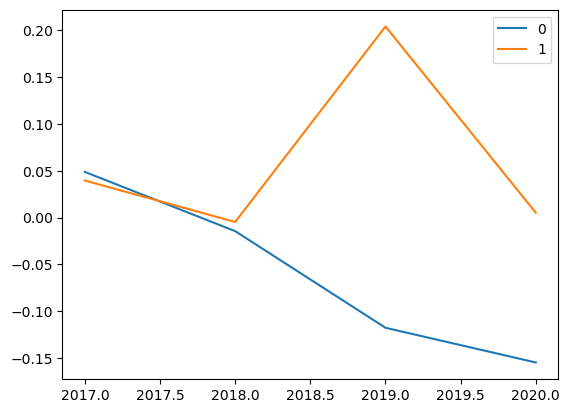

In [222]:
results.plot()

<Axes: >

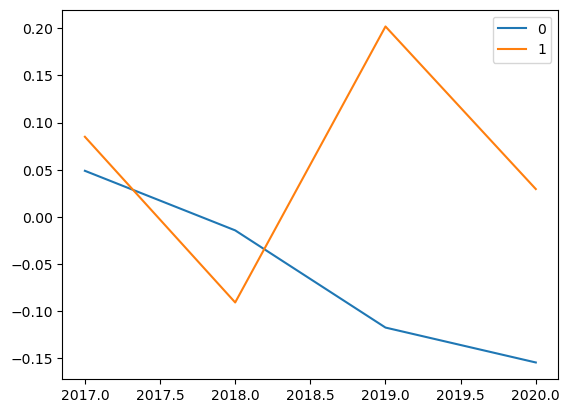

In [219]:
results.plot()